In [1]:
import numpy as np
import sympy as sp
from numpy.linalg import inv
import random
import matplotlib.pyplot as plt

## Start off my initializing the knowns

In [2]:
length = 750
width = 500
radius = 20
distance_between_wheels = 85
refresh_rate = 0.5
maximum_motor_speed = np.pi
starting_state = np.array([0,500,7*np.pi/4])
starting_speed = [0,0]
std_motor_speed = 0.05*maximum_motor_speed
std_laser = 10
std_imu = 0.5
time_update = 0.1

In [3]:
class Robot():
    def __init__(self, radius, distance_between_wheels, maximum_motor_speed, refresh_rate):
        self.current_state = starting_state
        self.speed = np.array([0,0])
        self.theta = self.current_state[2]
        self.std_motor_speed = 0.05*maximum_motor_speed
        self.std_laser = 10
        self.std_imu = 0.25
        self.radius = radius
        self.distance_between_wheels = distance_between_wheels
        self.maximum_motor_speed = maximum_motor_speed
        self.std_motor_speed = 0.05*self.maximum_motor_speed
        self.refresh_rate = refresh_rate
        self.H = np.eye(3)
        self.P = np.eye(3)
        x_position,y_position,theta,left_speed,right_speed,radius,distance,time= sp.symbols('x_position,y_position,theta,left_speed,right_speed,radius,distance,time')
        self.function = sp.Matrix([[x_position+1/2*sp.cos(theta)*(left_speed+right_speed)*radius*time],
                          [y_position+1/2*sp.sin(theta)*(left_speed+right_speed)*radius*time],
                          [theta + (right_speed-left_speed)*radius/distance_between_wheels*time]])
        self.noise = np.diag([self.std_laser**2,self.std_laser**2, self.std_imu**2])
        self.function_derived_over_state = self.function.jacobian(sp.Matrix([x_position, y_position, theta]))
        self.function_derived_over_input = self.function.jacobian(sp.Matrix([left_speed, right_speed]))
        self.subs = {x_position: self.current_state[0], y_position: self.current_state[1], theta: self.current_state[2], 
                     left_speed: self.speed[0], right_speed: self.speed[1], radius: self.radius, distance_between_wheels: self.distance_between_wheels, 
                     time: self.refresh_rate}
        self.left_speed = left_speed
        self.right_speed = right_speed
        self.time = 0
        
    def movement(self, current_state, speed, refresh_rate):
        # current_state = [x,y,theta]
        left_speed = speed[0]
        right_speed = speed[1]
        theta = current_state[2]
        velocity = (left_speed + right_speed)*1/2*radius
        left_distance = left_speed*refresh_rate
        right_distance = right_speed*refresh_rate
        return current_state + np.array((sp.cos(theta)*velocity*refresh_rate, sp.sin(theta)*velocity*refresh_rate, (right_distance-left_distance)/1.5))
    
    def residual(self,measurement):
        residual = measurement - self.H.dot(self.current_state)
        residual[2] = residual[2] % (2*np.pi)
        if residual[2] > np.pi:
            residual[2] -= 2*np.pi
        
        return residual
    
    def add_noise(self, current_state):
        random_array = np.array([[random.uniform(0,4),random.uniform(0,4),random.uniform(0,4)]])
        state_with_error = np.sqrt(self.noise).dot(np.random.randn(3))
        return current_state+state_with_error
    
    
    def prediction(self, speed):
        self.current_state = self.movement(self.current_state, speed, self.refresh_rate)

        self.subs[self.theta] = self.current_state[2]
        self.subs[self.left_speed] = speed[0]
        self.subs[self.right_speed] = speed[1]

        function_derived_over_state = np.array(self.function_derived_over_state.evalf(subs=self.subs)).astype(float)
        function_derived_over_input = np.array(self.function_derived_over_input.evalf(subs=self.subs)).astype(float)

        M = np.array([[self.std_motor_speed**2, 0], 
                   [0, self.std_motor_speed**2]])

        self.P = np.dot(function_derived_over_state, self.P).dot(function_derived_over_state.T) + np.dot(function_derived_over_input, M).dot(function_derived_over_input.T)
        
        self.time += 1
    
    def update(self, residual):
        K1 = np.dot(self.P,self.H.T)
        K2 = inv(np.dot(self.H,self.P).dot(self.H.T)+self.noise)
        self.K = K1.dot(K2)
        self.current_state = self.current_state + self.K.dot(residual)
        self.P = (np.eye(3)-self.K.dot(self.H)).dot(self.P)
    

In [4]:
robot = Robot(radius, distance_between_wheels, maximum_motor_speed, refresh_rate)

In [5]:
from filterpy.stats import plot_covariance_ellipse
def simulate(time_to_run, robot):
    current_state = robot.current_state
    std_motor_speed = robot.std_motor_speed
    refresh_rate = robot.refresh_rate
    refresh_system = refresh_rate/time_update
    x_trajectory,  y_trajectory = [] , []
    x_before, y_before = [] , []
    x_after, y_after = [] , []
    speed = np.array((np.pi/2, np.pi/2))
    ellipse_step = 20
    x_measurement, y_measurement = [] , []
    plt.figure(figsize = (20,15))

    for i in range(0, int(time_to_run/time_update)):
        if i >= 100:
            speed = np.array([1,1.5])
        if i >= 150:
            speed = np.array([1.5,1])
        if i >= 250:
            speed = np.array([1,1])
        if i >= 400:
            speed = np.array([1,1])
        
        actual_speed = speed + std_motor_speed*np.random.randn(2)
        current_state = robot.movement(current_state, actual_speed, time_update)
        x_trajectory.append(current_state[0])
        y_trajectory.append(current_state[1])
        if i % refresh_system == 0:
            if i % ellipse_step == 0:
                plot_covariance_ellipse((robot.current_state[0], robot.current_state[1]),robot.P[0:2, 0:2],std=6, facecolor='k',alpha=0.3)
            robot.prediction(speed)
            x_before.append(robot.current_state[0])
            y_before.append(robot.current_state[1])
            noise = robot.add_noise(current_state)
            x_measurement.append(noise[0])
            y_measurement.append(noise[1])
            residual = robot.residual(noise)
            robot.update(residual)
            x_after.append(robot.current_state[0])
            y_after.append(robot.current_state[1])
            if i % ellipse_step == 0:
                plot_covariance_ellipse((robot.current_state[0], robot.current_state[1]),robot.P[0:2, 0:2],std=6, facecolor='g',alpha=0.8)
    
    plt.grid(True)
    plt.xlim((0,750))
    plt.ylim((0,500))
    plt.plot(x_trajectory,y_trajectory)
    plt.show()

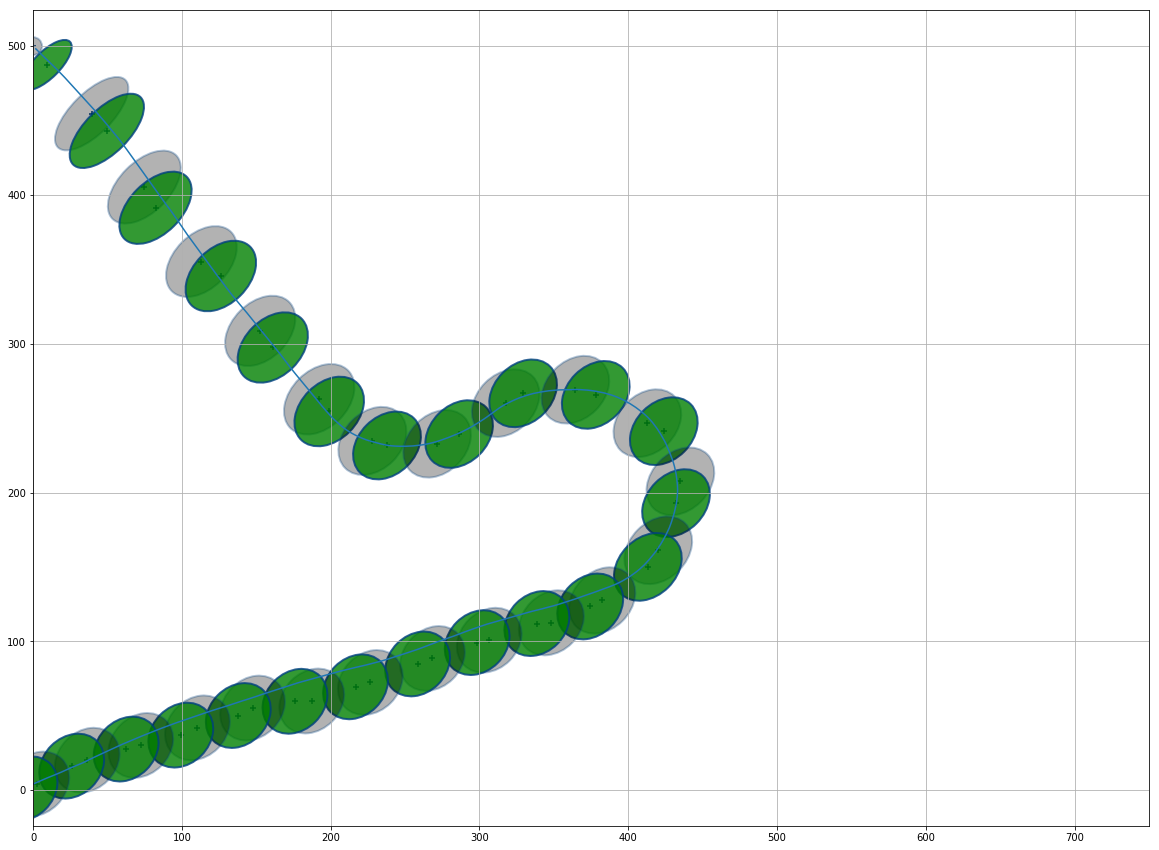

In [6]:
simulate(100, robot)